# What genre of music contains the most connected network?

# Data:

## The data comes from: https://snap.stanford.edu/data/feather-deezer-social.html

## This network is collected from a social network of Deezer users in 2017. Deezer is a music streaming platform. The platform allows you to follow users. This network contains mutual follower relationships, so it doesn't contain a direction. Each node represents a user, with metadata attached, denoting the genres that they enjoy, based on the artists that are liked by the users. There are three different networks that are included. Data from: Romania, Croatia, and Hungary

## First We Will Import the necessary packages

In [132]:
## Import Packages
import pandas as pd
import numpy as np
import networkx as nx
import nxviz as nv
import matplotlib.pyplot as plt
import json
import igraph as ig
import pyvis as pv
from IPython.core.display import display, HTML
import seaborn as sns


C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\290526204.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Next we will read in the data.
# The data consists of:

## * An excel file that has information on the edges in the network

## * A json file that has metadata information on the nodes in the dataset. The data contains genres that the nodes (users) liked


In [2]:
## Read in our dataframes with our edge information
df_ro = pd.read_csv("RO_edges.csv")
df_hr = pd.read_csv("HR_edges.csv")
df_hu = pd.read_csv("HU_edges.csv")



## Read in the json files from paths and then load them using the json.loads() function

json_list = ["RO_genres.json", "HR_genres.json", "HU_genres.json"]

with open(json_list[0], "r") as j:
    json1 = json.loads(j.read())
with open(json_list[1], "r") as j:
    json2 = json.loads(j.read())
with open(json_list[2], "r") as j:
    json3 = json.loads(j.read())

In [3]:
## Look at dataframe and datatypes
## Currently each edge relationship is denoted by two colummns with a node in each
print(df_ro.head())
print(df_ro.dtypes)

   node_1  node_2
0       0   37825
1       0   17224
2       0    6356
3       1   18053
4       1   31265
node_1    int64
node_2    int64
dtype: object


## Each node can have many different musical categories attached to it

In [4]:
## Look at the metadata that is contained within the json file
print(list(json1.items())[:2])

[('0', ['Films/Games', 'Dance', 'Pop', 'International Pop', 'Techno/House', 'R&B', 'Contemporary R&B', 'Film Scores', 'Electro']), ('1', ['Reggae', 'Electro', 'Dance', 'Rap/Hip Hop', 'Metal', 'Pop', 'East Coast', 'Techno/House', 'Rock', 'Alternative', 'Hard Rock'])]


In [5]:
## Convert the jsons to dataframes

genre_ro = pd.DataFrame(list(json1.items()), columns = ["node", "genre_list"])
genre_hr = pd.DataFrame(list(json2.items()), columns = ["node", "genre_list"]) 
genre_hu = pd.DataFrame(list(json3.items()), columns = ["node", "genre_list"]) 

## Look at the structure
genre_ro.head()

,node,genre_list
0,0,"[Films/Games, Dance, Pop, International Pop, T..."
1,1,"[Reggae, Electro, Dance, Rap/Hip Hop, Metal, P..."
2,2,[Pop]
3,3,"[Dance, Rap/Hip Hop, Pop, Disco, Alternative, ..."
4,4,"[Dance, Rap/Hip Hop, Contemporary R&B, Pop, Di..."


In [6]:
## look at data types:
genre_ro.dtypes

node          object
genre_list    object
dtype: object

In [7]:
genre_ro["node"] = genre_ro["node"].astype(int)
genre_hr["node"] = genre_hr["node"].astype(int)
genre_hu["node"] = genre_hu["node"].astype(int)

##  make sure the node is an int

genre_ro.dtypes

node           int32
genre_list    object
dtype: object

In [8]:
## Data needs to be in a specific format to be easily read into a network. I will make

## Romanian Dataset
genre_ro["genre_list_dict"] = pd.DataFrame(genre_ro["genre_list"]).to_dict("records")
genre_ro["create_nodes"] = list(zip(genre_ro.node, genre_ro.genre_list_dict))

## Hungarian Dataset
genre_hu["genre_list_dict"] = pd.DataFrame(genre_hu["genre_list"]).to_dict("records")
genre_hu["create_nodes"] = list(zip(genre_hu.node, genre_hu.genre_list_dict))

## Croatian Dataset

genre_hr["genre_list_dict"] = pd.DataFrame(genre_hr["genre_list"]).to_dict("records")
genre_hr["create_nodes"] = list(zip(genre_hr.node, genre_hr.genre_list_dict))
genre_hr.head()

In [9]:
## A column for the edge list will make working with the data more convenient
df_ro["edges"] = list(zip(df_ro.node_1, df_ro.node_2))
df_hr["edges"] = list(zip(df_hr.node_1, df_hr.node_2))
df_hu["edges"] = list(zip(df_hu.node_1, df_hu.node_2))

## The information on the dataset said that there were 84 total genres that the nodes could have. By looping over the dataframe of node metadata, we can check this

In [10]:
## Initiate an empty list to store genres
list_of_genres = []
for row in genre_ro["genre_list_dict"]:
    for music_list in row.values():
        for item in music_list:
            if item not in list_of_genres:
                list_of_genres.append(item)

## 84 values are expected
len(list_of_genres)

84

## Lets look at what some of the categories that are included in the networks:

In [11]:
list_of_genres[:20]

['Films/Games', 'Dance', 'Pop', 'International Pop', 'Techno/House']

## Lets determine the frequency of genres in each of the datasets 

In [12]:
country_genre_counts = pd.DataFrame()
country_genre_counts["category"] = list_of_genres
df_list = [genre_ro, genre_hu, genre_hr]
df_str = ["romanian_counts",  "hungarian_counts", "croatian_counts"]
index = 0
for df in df_list:
    genre_counts = {}
    for row in df["genre_list_dict"]:
        for music_list in row.values():
            for item in music_list:
                if item not in genre_counts.keys():
                    genre_counts[item] = 1
                else:
                    genre_counts[item] += 1
    country_genre_counts[df_str[index]] = genre_counts.values()
    index += 1

## Now we can look at what genres are the most popular in the three different networks. I have created a filtered list of the genres as well, that only contains genres that have at least 1000 nodes. This is for when centrality measures are being measured, as genres with small amount of nodes might have large centrality measures that are not exactly honest due to the size of the sample.

In [169]:
## Create a list of genres which are filtered so that they must contain at least 1000 nodes. This will be useful for later centrality measures
romanian_genre_list = country_genre_counts["category"][country_genre_counts["romanian_counts"] > 1000]

country_genre_counts.sort_values(by  = ["romanian_counts"], ascending= False).head(10)

,category,romanian_counts,hungarian_counts,croatian_counts
2,Pop,33420,18620,12030
1,Dance,21208,21033,12111
10,Rap/Hip Hop,18849,17585,10436
13,Rock,16630,5236,9435
8,Electro,16550,3820,27101
14,Alternative,14966,1848,7192
5,R&B,11933,25201,25998
3,International Pop,11620,9458,13723
20,Indie Rock,7365,10181,5333
0,Films/Games,7353,22749,47303


## Sorted by Hungarian Genre Counts:

In [171]:

hungarian_genre_list = country_genre_counts["category"][country_genre_counts["hungarian_counts"] > 1000]
country_genre_counts.sort_values(by = ["hungarian_counts"], ascending= False).head(10)

,category,romanian_counts,hungarian_counts,croatian_counts
7,Film Scores,6924,37889,20707
5,R&B,11933,25201,25998
0,Films/Games,7353,22749,47303
1,Dance,21208,21033,12111
2,Pop,33420,18620,12030
10,Rap/Hip Hop,18849,17585,10436
16,Disco,5841,13830,8926
17,Singer & Songwriter,5520,11134,3797
20,Indie Rock,7365,10181,5333
3,International Pop,11620,9458,13723


## Sorted by Croatian Genre Counts:

In [120]:
country_genre_counts.sort_values(by = ["croatian_counts"], ascending= False).head(10)
croatian_genre_list = country_genre_counts["category"][country_genre_counts["croatian_counts"] > 1000]
filtered_genres_list = [romanian_genre_list, hungarian_genre_list, croatian_genre_list]

## Interestingly, the top genres for all three countries are quite different. It will be cool to see if this has an impact on the connectedness of the networks, or if the most connected genre will still be consistent accross all of the networks. Romania enjoys more conventional genres, while Croatia and Hungary prefer movie/game scores as well as electronic or dance music

## Now lets Create our Networks:

### * For each country, a networkx network will be initiated

In [16]:
## initiate all networks
graph_ro = nx.Graph()
graph_hu = nx.Graph()
graph_cr = nx.Graph()

## Create romanian Network
graph_ro.add_nodes_from(genre_ro["create_nodes"], key =int)
graph_ro.add_edges_from(df_ro["edges"])

## Create hungarian Network
graph_hu.add_nodes_from(genre_hu["create_nodes"], key =int)
graph_hu.add_edges_from(df_hu["edges"])


## Create croatian network
graph_cr.add_nodes_from(genre_hr["create_nodes"], key =int)
graph_cr.add_edges_from(df_hr["edges"])


## Lets look at the data contained within our network nodes:

In [17]:
list(graph_ro.nodes(data = True))[:2]

[(0,
  {'key': int,
   'genre_list': ['Films/Games',
    'Dance',
    'Pop',
    'International Pop',
    'Techno/House',
    'R&B',
    'Contemporary R&B',
    'Film Scores',
    'Electro']}),
 (1,
  {'key': int,
   'genre_list': ['Reggae',
    'Electro',
    'Dance',
    'Rap/Hip Hop',
    'Metal',
    'Pop',
    'East Coast',
    'Techno/House',
    'Rock',
    'Alternative',
    'Hard Rock']})]

## Check the number of nodes and edges:

In [18]:
## Romanian Counts
print("Romanian Nodes: " + str(graph_ro.number_of_nodes()))
print("Romanian Edges: " + str(graph_ro.number_of_edges()))

## Croatian Counts

print("Croatian Nodes: " + str(graph_cr.number_of_nodes()))
print("Croatian Edges: " + str(graph_cr.number_of_edges()))

## Hungarian Counts

print("Hungarian Nodes: " + str(graph_hu.number_of_nodes()))
print("Hungarian Edges: " + str(graph_hu.number_of_edges()))

Romanian Nodes: 41773
Romanian Edges: 125826
Croatian Nodes: 54573
Croatian Edges: 498202
Hungarian Nodes: 47538
Hungarian Edges: 222887


## The network is too large to reliably visualize, but we can take a sample of it and visualize that:

In [ ]:
sample  = df_ro.sample(1000, random_state = 1)
sample.head(10)

In [ ]:
net = pv.network.Network(height = "1000px", width = "100%", notebook = False )
pyviz_nodes = list(set([*sample.node_1, *sample.node_2]))
pyviz_edges = sample[["node_1","node_2"]].values.tolist()
net.add_nodes(pyviz_nodes)
net.add_edges(pyviz_edges)


In [ ]:
net.show("practice_net.html", notebook = False)

## The Croatian network is the largest and likely the most connected. Now the centrality measures should be examined.

In [19]:
## Romanian Centrality measures
degree_centrality_ro = nx.degree_centrality(graph_ro)
eigen_centrality_ro = nx.eigenvector_centrality(graph_ro)

## Croatian Centrality measures
degree_centrality_cr = nx.degree_centrality(graph_cr)
eigen_centrality_cr = nx.eigenvector_centrality(graph_cr)

## Hungarian Centrality measures
degree_centrality_hu = nx.degree_centrality(graph_hu)
eigen_centrality_hu = nx.eigenvector_centrality(graph_hu)

## In order to find betweenness centrality, we must convert the network to an igraph network. The algorithm that networkx uses is too slow for networks that are as large as the three that are being examined

igraph_ro = ig.Graph.from_networkx(graph_ro)
igraph_cr = ig.Graph.from_networkx(graph_cr)
igraph_hu = ig.Graph.from_networkx(graph_hu)


In [20]:
## Calculate beteenness centrality

betweenness_centrality_ro = igraph_ro.betweenness(directed = False)

In [21]:
betweenness_centrality_cr = igraph_cr.betweenness(directed = False)

In [22]:
betweenness_centrality_hu = igraph_hu.betweenness(directed =False)

In [23]:
## lets add centrality values to our genre dataframe

## Romanian Dataframe
genre_ro["degree_centrality"] = degree_centrality_ro.values()
genre_ro["eigenvector_centrality"] = eigen_centrality_ro.values()
genre_ro["betweenness_centrality"] = betweenness_centrality_ro
## Croation Dataframe
genre_hr["degree_centrality"] = degree_centrality_cr.values()
genre_hr["eigenvector_centrality"] = eigen_centrality_cr.values()
genre_hr["betweenness_centrality"] = betweenness_centrality_cr

## Hungarian Dataframe
genre_hu["degree_centrality"] = degree_centrality_hu.values()
genre_hu["eigenvector_centrality"] = eigen_centrality_hu.values()
genre_hu["betweenness_centrality"] = betweenness_centrality_hu

In [24]:
## Sort hungarian values by descending degree_centrality
genre_hu.sort_values(by = ["betweenness_centrality"], ascending= False)

,node,genre_list,genre_list_dict,create_nodes,degree_centrality,eigenvector_centrality,betweenness_centrality
14900,14900,"[Techno/House, Dance, Electro, Pop]","{'genre_list': ['Techno/House', 'Dance', 'Elec...","(14900, {'genre_list': ['Techno/House', 'Dance...",0.002356,3.175087e-02,8.877837e+06
40491,40491,"[Comedy, Dance, Rap/Hip Hop, Pop, R&B, Rock, E...","{'genre_list': ['Comedy', 'Dance', 'Rap/Hip Ho...","(40491, {'genre_list': ['Comedy', 'Dance', 'Ra...",0.002041,8.660385e-03,7.066625e+06
24218,24218,"[International Pop, Rap/Hip Hop, Latin Music, ...","{'genre_list': ['International Pop', 'Rap/Hip ...","(24218, {'genre_list': ['International Pop', '...",0.001851,7.635477e-03,5.833603e+06
14597,14597,"[Rap/Hip Hop, Pop]","{'genre_list': ['Rap/Hip Hop', 'Pop']}","(14597, {'genre_list': ['Rap/Hip Hop', 'Pop']})",0.001725,8.568430e-03,5.663767e+06
15724,15724,"[Films/Games, Dancefloor, International Pop, R...","{'genre_list': ['Films/Games', 'Dancefloor', '...","(15724, {'genre_list': ['Films/Games', 'Dancef...",0.001830,9.452062e-03,4.975937e+06
...,...,...,...,...,...,...,...
16573,16573,[Rap/Hip Hop],{'genre_list': ['Rap/Hip Hop']},"(16573, {'genre_list': ['Rap/Hip Hop']})",0.000021,7.779920e-07,0.000000e+00
41217,41217,"[Pop, Rock]","{'genre_list': ['Pop', 'Rock']}","(41217, {'genre_list': ['Pop', 'Rock']})",0.000021,9.109243e-07,0.000000e+00
6653,6653,"[International Pop, Rap/Hip Hop, Pop, R&B]","{'genre_list': ['International Pop', 'Rap/Hip ...","(6653, {'genre_list': ['International Pop', 'R...",0.000021,2.575258e-05,0.000000e+00
6666,6666,"[Films/Games, Indie Rock, R&B, International P...","{'genre_list': ['Films/Games', 'Indie Rock', '...","(6666, {'genre_list': ['Films/Games', 'Indie R...",0.000021,9.625089e-06,0.000000e+00


In [25]:
df_ro

,node_1,node_2,edges
0,0,37825,"(0, 37825)"
1,0,17224,"(0, 17224)"
2,0,6356,"(0, 6356)"
3,1,18053,"(1, 18053)"
4,1,31265,"(1, 31265)"
...,...,...,...
125821,40084,41686,"(40084, 41686)"
125822,41507,41641,"(41507, 41641)"
125823,41592,41710,"(41592, 41710)"
125824,41635,28844,"(41635, 28844)"


In [68]:
test_avg = np.average(genre_hu[genre_hu["genre_list"].apply(lambda x: "Pop" in x)]["degree_centrality"])
test_avg

0.0001972068199988561

In [71]:
test_dict = {}
for genre in list_of_genres:
    test_dict[genre] = np.average(genre_hr[genre_hr["genre_list"].apply(lambda x: genre in x)]["degree_centrality"])
    
test_dict

test_df = pd.DataFrame(data = test_dict, index = [0])
test_df = pd.melt(test_df, var_name = "category", value_name =  "centrality").sort_values(by = "centrality", ascending= False)
test_df.head(15)

C:\Users\Steve\AppData\Roaming\Python\Python310\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Steve\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,category,centrality
74,Classical Period,0.000482
29,Dubstep,0.000444
79,Classic Blues,0.000421
56,West Coast,0.000418
21,Dancefloor,0.000412
45,Grime,0.000398
33,Electro Pop/Electro Rock,0.000398
30,Electro Hip Hop,0.000392
44,Folk,0.000382
40,Comedy,0.000373


In [121]:
centrality_hr = pd.DataFrame()
centrality_ro = pd.DataFrame()
centrality_hu = pd.DataFrame()

str_list = ["centrality_ro", "centrality_hu", "centrality_hr"]
counts_list = ["romanian_counts","hungarian_counts", "croatian_counts"]
centrality_dict = {}
index = 0
for df in df_list:
    temp_dict = {}
    for genre in filtered_genres_list[index]:
        temp_dict[genre] =  np.average(df[df["genre_list"].apply(lambda x: genre in x)]["degree_centrality"])
    
    centrality_dict[str_list[index]] = temp_dict
    
    print(centrality_dict)
    index += 1

{'centrality_ro': {'Films/Games': 0.0001520041464105709, 'Dance': 0.0001473528785695247, 'Pop': 0.00014416768054881498, 'International Pop': 0.0001512925753986521, 'Techno/House': 0.0001496612979946525, 'R&B': 0.00015128034715902657, 'Contemporary R&B': 0.0001583709916154563, 'Film Scores': 0.00015358746745074205, 'Electro': 0.00014951254587918354, 'Reggae': 0.00014525016458589922, 'Rap/Hip Hop': 0.00015236097184198342, 'Metal': 0.00015183380017566998, 'East Coast': 0.00015454414386498346, 'Rock': 0.00014606250383996183, 'Alternative': 0.00015304888021646024, 'Hard Rock': 0.00014718013933213338, 'Disco': 0.00013980066711845521, 'Singer & Songwriter': 0.00015633088248559815, 'Latin Music': 0.00013596917127768369, 'Indie Rock': 0.00015377825468214316, 'Dancefloor': 0.00015991907439093128, 'Indie Pop/Folk': 0.00015132299657288537, 'Indie Rock/Rock pop': 0.00015686954829397619, 'Indie Pop': 0.00015570728605762878, 'Country': 0.00014078452225964251, 'Rock & Roll/Rockabilly': 0.0001336726895

[        node                                         genre_list  \
 0          0  [Films/Games, Dance, Pop, International Pop, T...   
 1          1  [Reggae, Electro, Dance, Rap/Hip Hop, Metal, P...   
 2          2                                              [Pop]   
 3          3  [Dance, Rap/Hip Hop, Pop, Disco, Alternative, ...   
 4          4  [Dance, Rap/Hip Hop, Contemporary R&B, Pop, Di...   
 ...      ...                                                ...   
 41768  41768                       [R&B, Pop, Contemporary R&B]   
 41769  41769            [Film Scores, Rap/Hip Hop, Films/Games]   
 41770  41770  [Dancefloor, International Pop, Rap/Hip Hop, P...   
 41771  41771                                 [Rap/Hip Hop, Pop]   
 41772  41772  [Rap/Hip Hop, Pop, Rock, Electro Hip Hop, Alte...   
 
                                          genre_list_dict  \
 0      {'genre_list': ['Films/Games', 'Dance', 'Pop',...   
 1      {'genre_list': ['Reggae', 'Electro', 'Dance', ...   

In [123]:
eigen_centrality_dict = {}
index = 0
for df in df_list:
    temp_dict = {}
    for genre in filtered_genres_list[index]:
        temp_dict[genre] =  np.average(df[df["genre_list"].apply(lambda x: genre in x)]["eigenvector_centrality"])
    
    eigen_centrality_dict[str_list[index]] = temp_dict
    
    print(eigen_centrality_dict)
    index += 1

{'centrality_ro': {'Films/Games': 0.0009615742656176893, 'Dance': 0.0007881083560287957, 'Pop': 0.0007880101229926749, 'International Pop': 0.0010409209589494466, 'Techno/House': 0.0007641700191162318, 'R&B': 0.0008581091897466059, 'Contemporary R&B': 0.0011078036912407422, 'Film Scores': 0.000990558804546733, 'Electro': 0.0007664433624804956, 'Reggae': 0.0005243692947380561, 'Rap/Hip Hop': 0.0008348480326174553, 'Metal': 0.0007148702930690878, 'East Coast': 0.0005667450634478346, 'Rock': 0.0007450732613627192, 'Alternative': 0.0008542549891337461, 'Hard Rock': 0.0005834425767844222, 'Disco': 0.0006458038235956017, 'Singer & Songwriter': 0.0008820443711760186, 'Latin Music': 0.000622536410234486, 'Indie Rock': 0.0008518746166479473, 'Dancefloor': 0.00121910993793313, 'Indie Pop/Folk': 0.0006970497158061135, 'Indie Rock/Rock pop': 0.0006497377522501977, 'Indie Pop': 0.0008248732753188662, 'Country': 0.0005300394355953599, 'Rock & Roll/Rockabilly': 0.00037480034463927166, 'Blues': 0.0003

In [124]:
centrality_df = pd.DataFrame(data = centrality_dict["centrality_ro"], index = [0])
centrality_df = centrality_df.append(centrality_dict["centrality_hu"], ignore_index= True)
centrality_df = centrality_df.append(centrality_dict["centrality_hr"], ignore_index= True)
centrality_df["dataset"] = ["romanian", "hungarian", "croatian"]
centrality_df = pd.melt(centrality_df,id_vars= "dataset")
centrality_df


C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\1912471189.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centrality_df = centrality_df.append(centrality_dict["centrality_hu"], ignore_index= True)
C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\1912471189.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centrality_df = centrality_df.append(centrality_dict["centrality_hr"], ignore_index= True)


,dataset,variable,value
0,romanian,Films/Games,0.000152
1,hungarian,Films/Games,0.000201
2,croatian,Films/Games,0.000351
3,romanian,Dance,0.000147
4,hungarian,Dance,0.000202
...,...,...,...
124,hungarian,Musicals,NaN
125,croatian,Musicals,0.000319
126,romanian,Vocal jazz,NaN
127,hungarian,Vocal jazz,NaN


In [125]:
eigen_centrality_df = pd.DataFrame(data = eigen_centrality_dict["centrality_ro"], index = [0])
eigen_centrality_df = eigen_centrality_df.append(eigen_centrality_dict["centrality_hu"], ignore_index= True)
eigen_centrality_df = eigen_centrality_df.append(eigen_centrality_dict["centrality_hr"], ignore_index= True)
eigen_centrality_df["dataset"] = ["romanian", "hungarian", "croatian"]
eigen_centrality_df = pd.melt(eigen_centrality_df,id_vars= "dataset")
eigen_centrality_df



C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\3200914694.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eigen_centrality_df = eigen_centrality_df.append(eigen_centrality_dict["centrality_hu"], ignore_index= True)
C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\3200914694.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eigen_centrality_df = eigen_centrality_df.append(eigen_centrality_dict["centrality_hr"], ignore_index= True)


,dataset,variable,value
0,romanian,Films/Games,0.000962
1,hungarian,Films/Games,0.000588
2,croatian,Films/Games,0.002096
3,romanian,Dance,0.000788
4,hungarian,Dance,0.000570
...,...,...,...
124,hungarian,Musicals,NaN
125,croatian,Musicals,0.001566
126,romanian,Vocal jazz,NaN
127,hungarian,Vocal jazz,NaN


In [128]:
eigen_centrality_df[eigen_centrality_df["dataset"]== "romanian"].sort_values(by = ["value"], ascending= False).head(15)

,dataset,variable,value
81,romanian,Dubstep,0.001480
60,romanian,Dancefloor,0.001219
18,romanian,Contemporary R&B,0.001108
84,romanian,Kids,0.001085
9,romanian,International Pop,0.001041
21,romanian,Film Scores,0.000991
0,romanian,Films/Games,0.000962
51,romanian,Singer & Songwriter,0.000882
15,romanian,R&B,0.000858
42,romanian,Alternative,0.000854


In [129]:
eigen_centrality_df[eigen_centrality_df["dataset"]== "hungarian"].sort_values(by = ["value"], ascending= False).head(15)

,dataset,variable,value
82,hungarian,Dubstep,0.000697
10,hungarian,International Pop,0.000684
61,hungarian,Dancefloor,0.000683
7,hungarian,Pop,0.000675
100,hungarian,Alternative Country,0.000631
16,hungarian,R&B,0.000625
52,hungarian,Singer & Songwriter,0.000621
19,hungarian,Contemporary R&B,0.000610
31,hungarian,Rap/Hip Hop,0.000609
22,hungarian,Film Scores,0.000601


In [130]:
eigen_centrality_df[eigen_centrality_df["dataset"]== "croatian"].sort_values(by = ["value"], ascending= False).head(15)

,dataset,variable,value
83,croatian,Dubstep,0.003272
122,croatian,Electro Hip Hop,0.002580
32,croatian,Rap/Hip Hop,0.002294
11,croatian,International Pop,0.002245
14,croatian,Techno/House,0.002229
20,croatian,Contemporary R&B,0.002195
5,croatian,Dance,0.002107
23,croatian,Film Scores,0.002106
2,croatian,Films/Games,0.002096
26,croatian,Electro,0.002085


C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\1022071994.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "croatian"][eigen_centrality_df["value"] > 0].sort_values(by = ["value"], ascending = False), x = "variable", y = "value")


<Axes: xlabel='variable', ylabel='value'>

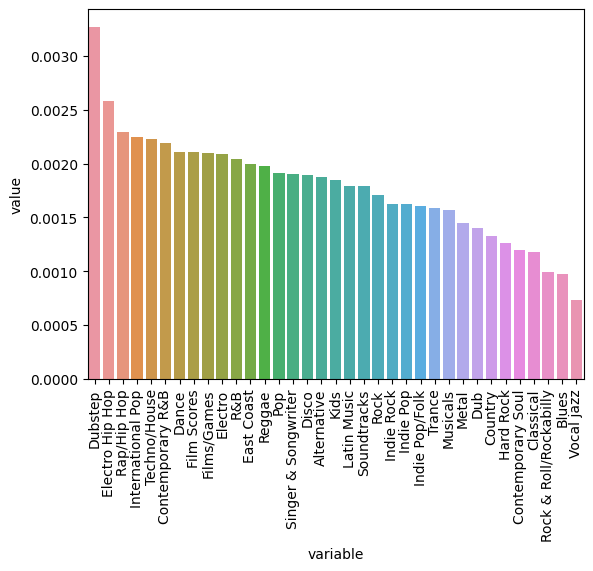

In [156]:
plt.xticks(rotation = 90)
sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "croatian"][eigen_centrality_df["value"] > 0].sort_values(by = ["value"], ascending = False), x = "variable", y = "value")

C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\3664059267.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "romanian"][eigen_centrality_df["value"] > 0].sort_values(by = ["value"], ascending = False), x = "variable", y = "value")


<Axes: xlabel='variable', ylabel='value'>

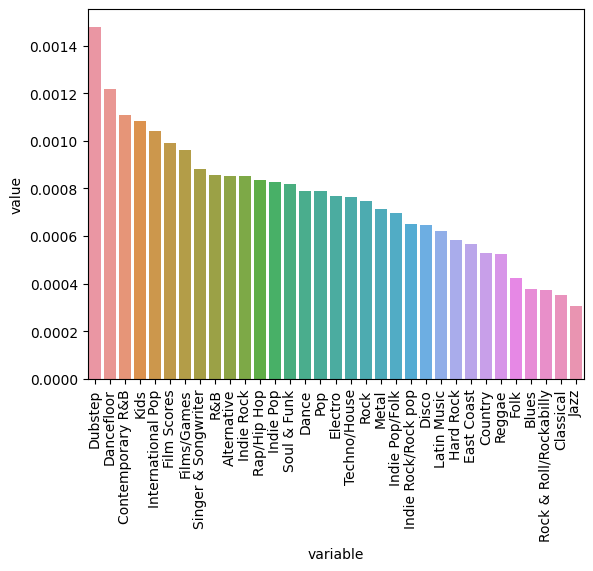

In [157]:
plt.xticks(rotation = 90)
sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "romanian"][eigen_centrality_df["value"] > 0].sort_values(by = ["value"], ascending = False), x = "variable", y = "value")

C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\3987149367.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "hungarian"][eigen_centrality_df["value"] > 0.0004].sort_values(by = ["value"], ascending = False), x = "variable", y = "value")


<Axes: xlabel='variable', ylabel='value'>

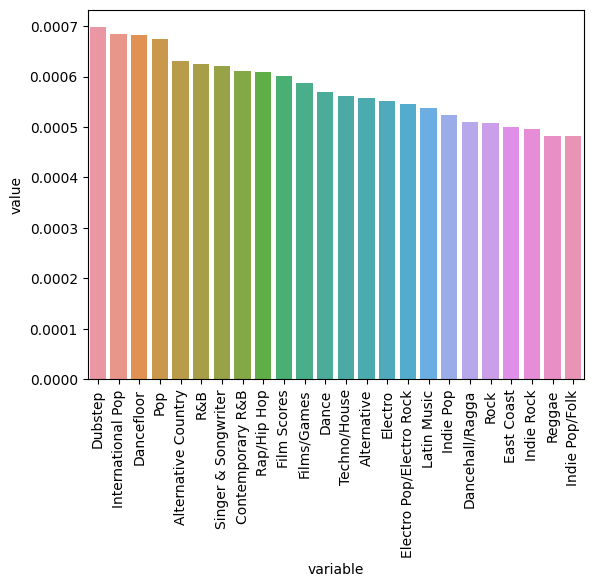

In [166]:
plt.xticks(rotation = 90)
sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "hungarian"][eigen_centrality_df["value"] > 0.0004].sort_values(by = ["value"], ascending = False), x = "variable", y = "value")

### Lets get summary values for the centrality of each of the music categories:

In [200]:
group_centrality = [genre_ro, genre_hu, genre_hr]
index = 0
cluster_df = pd.DataFrame()
country_selection = ["romanian", "hungarian", "croatian"]
graph_selection = [graph_ro,graph_hu,graph_cr]
for df in df_list:
    temp_df = pd.DataFrame()
    temp_list = []
    for genre in list_of_genres:
        temp_list.append(nx.group_degree_centrality(graph_selection[index],list(df[df["genre_list"].apply(lambda x: genre in x)]["node"])))
    temp_df["category"] = list_of_genres
    temp_df["country"] = country_selection[index]
    temp_df["group_degree_centrality"] = temp_list
    cluster_df = pd.concat([cluster_df,temp_df])
    index += 1

In [201]:
cluster_df = cluster_df.sort_values(by = ["group_degree_centrality"],ascending  = False)
cluster_df.head(20)

,category,country,group_degree_centrality
2,Pop,croatian,0.991197
2,Pop,hungarian,0.984869
2,Pop,romanian,0.963726
13,Rock,croatian,0.944742
1,Dance,croatian,0.941504
1,Dance,hungarian,0.926803
13,Rock,hungarian,0.916921
14,Alternative,croatian,0.912420
8,Electro,croatian,0.908588
10,Rap/Hip Hop,croatian,0.901858


<Axes: xlabel='category', ylabel='group_degree_centrality'>

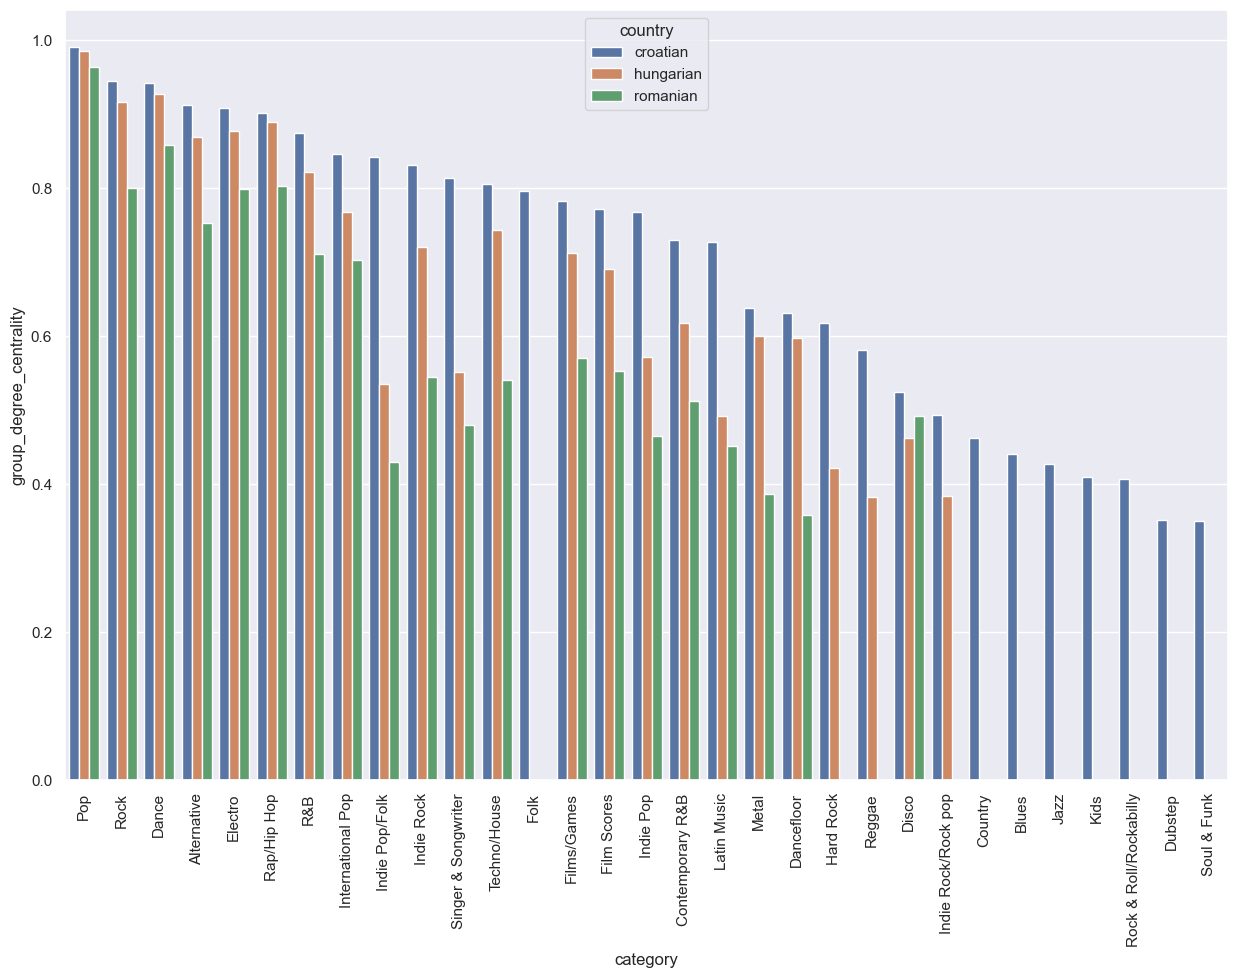

In [215]:
sns.set_theme(rc = {'figure.figsize':(15,10)})
plt.xticks(rotation = 90)
sns.barplot(data = cluster_df[cluster_df["group_degree_centrality"] > 0.35], x = "category", y = "group_degree_centrality",hue = "country")

## Unlike when we evaluate the nodes on an individual basis, evaluating the categories on a group basis results in more consistent results across the board. Pop, rock, dance, alternative, electro, hip hop, and international pop have the highest group centrality in all of the countries. Pop has a value that is nearly 1, meaning that almost all nodes that don't contain pop as a category are still connected to a node with pop in their metadata somewhere in the network.

In [220]:
country_genre_counts.head()

,category,romanian_counts,hungarian_counts,croatian_counts
0,Films/Games,7353,22749,47303
1,Dance,21208,21033,12111
2,Pop,33420,18620,12030
3,International Pop,11620,9458,13723
4,Techno/House,6811,5158,21142


0          Films/Games
1                Dance
2                  Pop
3    International Pop
4         Techno/House
Name: category, dtype: object


<Axes: xlabel='category', ylabel='group_degree_centrality'>

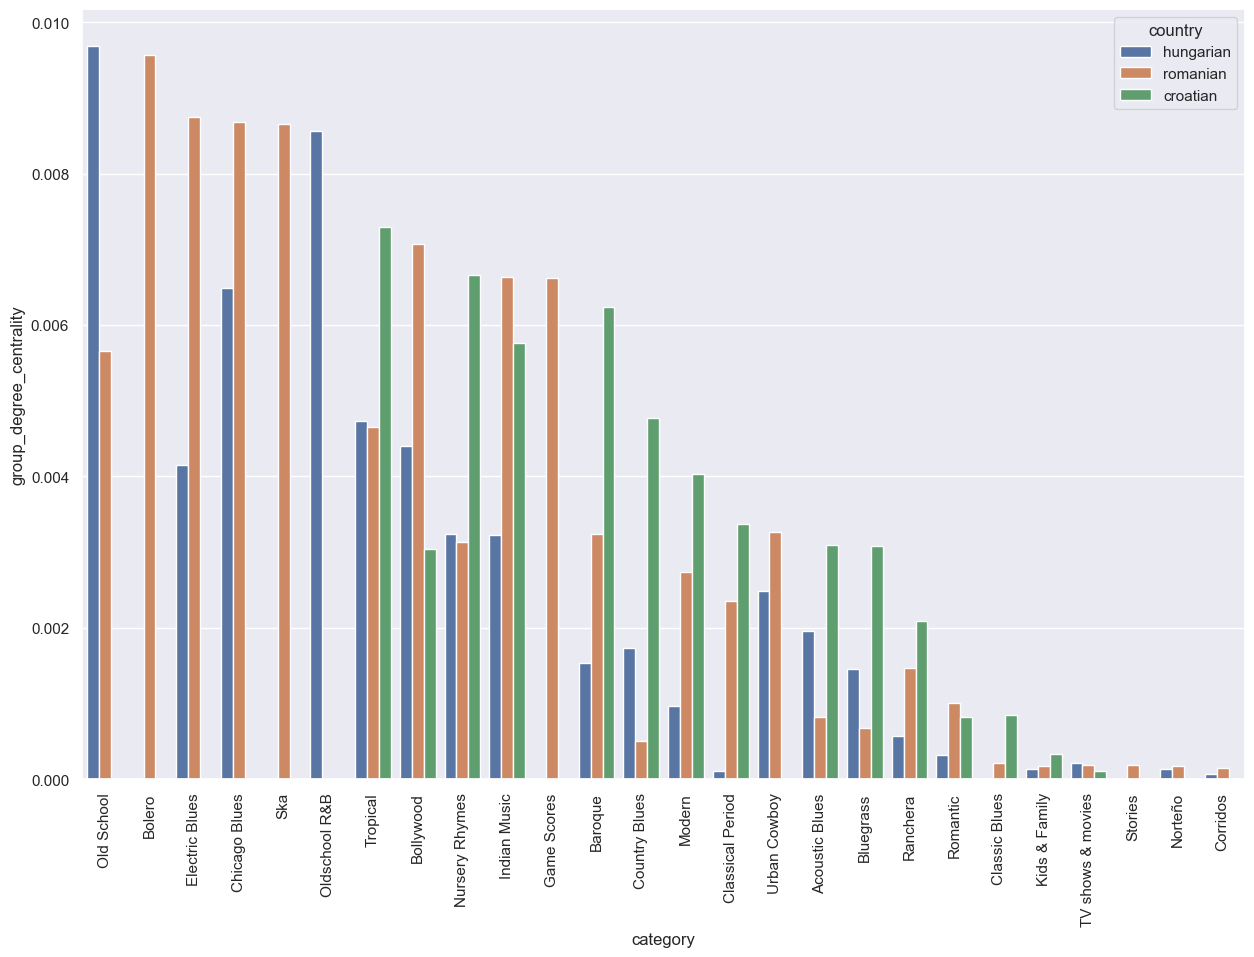

In [223]:
sns.set_theme(rc = {'figure.figsize':(15,10)})
plt.xticks(rotation = 90)
sns.barplot(data = cluster_df[cluster_df["group_degree_centrality"] < 0.01], x = "category", y = "group_degree_centrality",hue = "country")

In [239]:
cluster_df.head()

,category,country,group_degree_centrality
2,Pop,croatian,0.991197
2,Pop,hungarian,0.984869
2,Pop,romanian,0.963726
13,Rock,croatian,0.944742
1,Dance,croatian,0.941504


<Axes: xlabel='category', ylabel='group_degree_centrality'>

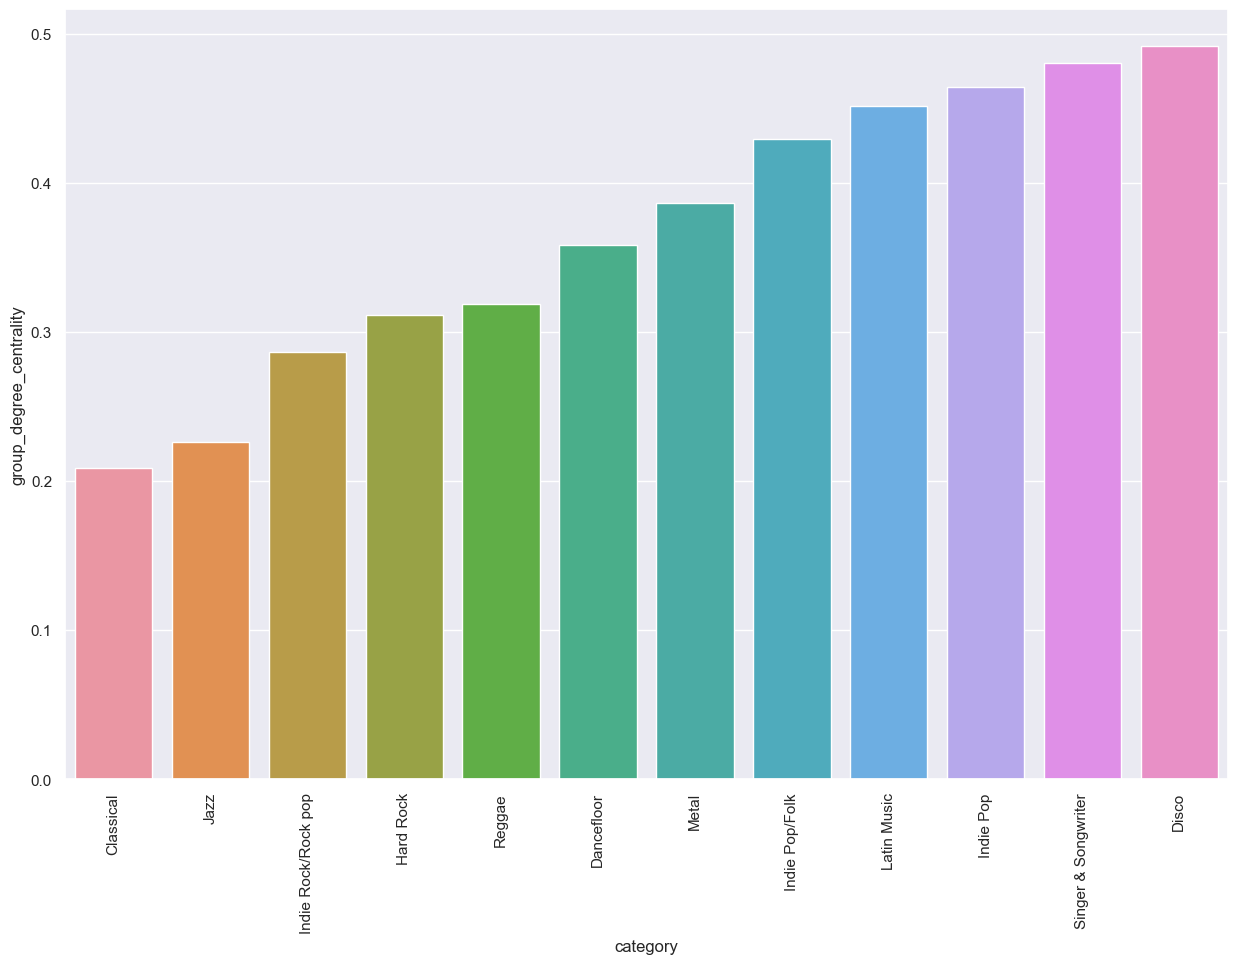

In [261]:
sns.set_theme(rc = {'figure.figsize':(15,10)})
plt.xticks(rotation = 90)
filter_df = country_genre_counts[country_genre_counts["romanian_counts"] >2000]["category"]

sns.barplot(data = cluster_df[(cluster_df["category"].isin(filter_df)) & (cluster_df["country"] == "romanian") & (cluster_df["group_degree_centrality"] < 0.5)].sort_values(by = "group_degree_centrality"), x = "category", y = "group_degree_centrality")



<Axes: xlabel='category', ylabel='group_degree_centrality'>

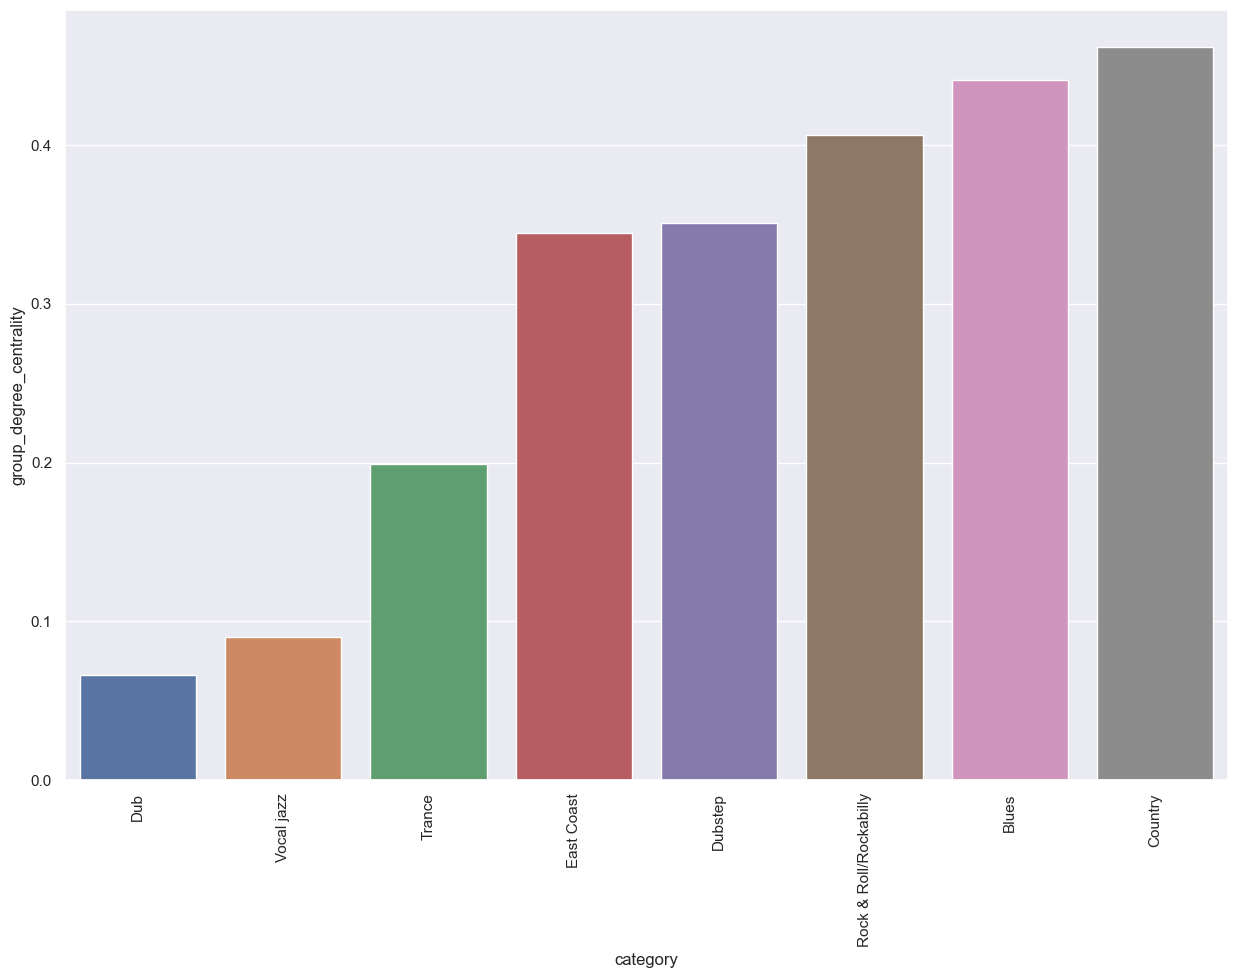

In [260]:
sns.set_theme(rc = {'figure.figsize':(15,10)})
plt.xticks(rotation = 90)
filter_df = country_genre_counts[country_genre_counts["croatian_counts"] > 2000]["category"]

sns.barplot(data = cluster_df[(cluster_df["category"].isin(filter_df)) & (cluster_df["country"] == "croatian") & (cluster_df["group_degree_centrality"] < 0.5)].sort_values(by = "group_degree_centrality"), x = "category", y = "group_degree_centrality")


<Axes: xlabel='category', ylabel='group_degree_centrality'>

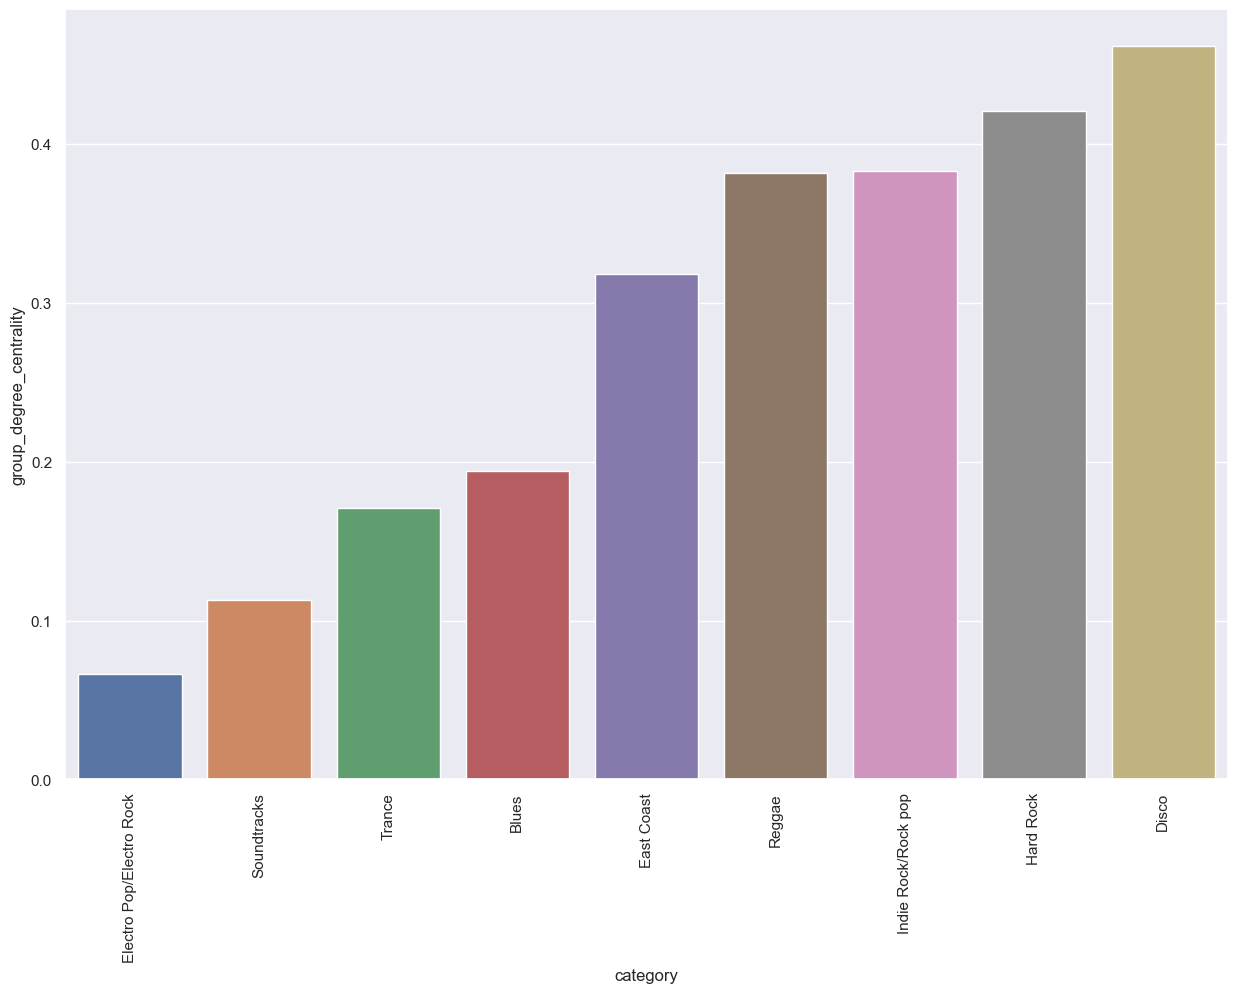

In [262]:
sns.set_theme(rc = {'figure.figsize':(15,10)})
plt.xticks(rotation = 90)
filter_df = country_genre_counts[country_genre_counts["hungarian_counts"] > 2000]["category"]

sns.barplot(data = cluster_df[(cluster_df["category"].isin(filter_df)) & (cluster_df["country"] == "hungarian") & (cluster_df["group_degree_centrality"] < 0.5)].sort_values(by = "group_degree_centrality"), x = "category", y = "group_degree_centrality")


## Certain musical categories are far less connected than others. We can see that categories such as game scores